# Happiness Investigation

In [33]:
#Import necessary libraries

import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans



In [34]:
'''
create a function that will take 9 different CSV files with a large quantity of different types of data
it will then read them, sort them by column names and extract relevant columns. it will then create 
a new column to specify which year that data point exists in.
Args:
    a filepath
'''

def happiness_reader(path):
    absolute_path = 'data/original/' + path 
    if path  == '2015_data.csv': #must specify. 2015 has an irregular data structure that needed addresing
        df = pd.read_csv(absolute_path, skiprows=3)
    else:
        df = pd.read_csv(absolute_path)
    df_2 = df.filter(regex='Country name|Country|country|Ladder score|Happiness score', axis=1) 
    #different files have different column names
    df_2 = df_2.rename(columns={
        'Ladder score': 'Happiness Index',
        'Happiness score': 'Happiness Index',  #standardize
        'Country name': 'Country',
        'country': 'Country'
    })
    df_2['Year'] = path.split('_')[0] #add a column for the first object in each list (year)
    column_order = ['Country', 'Year', 'Happiness Index']
    df_2 = df_2[column_order]
    new_path = 'data/generated/' + path
    df_2.to_csv(new_path, index=False) #copy to new csv file

In [35]:
# call happiness reader function by joining the csv files in the folder
folder_path = 'data/original/'
all_items = os.listdir(folder_path)
files = [f for f in all_items if os.path.isfile(os.path.join(folder_path, f))] # stack overflow 
for file in files:
    print(file)
    happiness_reader(file)

2017_data.csv
2016_data.csv
2023_data.csv
2022_data.csv
2024_data.csv
2020_data.csv
2021_data.csv
2015_data.csv
2019_data.csv
2018_data.csv


In [36]:
folder_path = 'data/generated/df_1'

csv_files = glob.glob(os.path.join(folder_path, '*.csv')) #join all generated generated data into a dataframe
dataframes = []

for file in csv_files:
    # 'low_memory, was because there was some issue with my running and the error code said to use low_memory=False
    
    df = pd.read_csv(file, low_memory=False)  #iterate through
    dataframes.append(df)
                                                
df_3 = pd.concat(dataframes, ignore_index=True) # concat horizontally merges 
df_3 = df_3.sort_values(by=['Country', 'Year'], ascending=[True, True])

new_path = 'data/generated/df_3.csv' # save to new csv files
df_3.to_csv(new_path, index=False)

df_3.shape # print to shape, goal is to maintain structure while adding on other indepedent variables

(1512, 3)

In [37]:
summary_stats = df['Happiness Index'].describe()
print(summary_stats)

count    156.000000
mean       5.375878
std        1.119507
min        2.905000
25%        4.453750
50%        5.378000
75%        6.168500
max        7.632000
Name: Happiness Index, dtype: float64


# Other Variables

    my goal is to keep adding independent variables to the 
    end of the dataframe, so that I can then explore them all together. 

In [38]:
def independent_var(path):
    #create a file path for my data from the IMF 
    file_path = 'data/economic_data/IMF/' + path
    df_4 = pd.read_csv(file_path)
    df_3 = pd.read_csv('data/generated/df_3.csv', low_memory=False)
    # drop column 0
    df_4 = df_4.drop(0, axis=0)

    df_4 = pd.melt(
        df_4,
        id_vars=['Country'],        
        var_name='Year',           
        value_name=os.path.splitext(path)[0]   # Name for the 'value' column
    )

    common_countries = df_3['Country'].unique()  # IMPORTANT STEP:  only include countries in original happiness dataset sincen it\
    #includes 153 countries and many other datasets have 193+. this step will be referenced as *1
    df_4 = df_4[df_4['Country'].isin(common_countries)]

    df_4['Year'] = df_4['Year'].astype(int) # filtering by year 
    df_4 = df_4[df_4['Year'].between(2015, 2024)]

    df_4 = df_4.sort_values(by=['Country', 'Year'], ascending=[True, True]) # filter by alphabetical order

    new_path = 'data/generated/economic_new/' + path
    df_4.to_csv(new_path, index=False)





In [39]:
# loop that iterates over each file in the IMF folder 
folder_path = 'data/economic_data/IMF/'
all_items = os.listdir(folder_path)
files = [f for f in all_items if os.path.isfile(os.path.join(folder_path, f))]
for file in files:
    print(file)
    independent_var(file)

    
    
    
    
    


Population in Millions.csv
Inflation.csv
unemployment.csv
GDP.csv


In [40]:
#INEQUALITY filtering

df_3 = pd.read_csv('data/generated/df_3.csv', low_memory=False)

df = pd.read_csv('data/economic_data/other factors/economic-inequality-gini-index.csv')
df = df.drop(['Code', '990179-annotations'], axis=1)
df = df.rename(columns={'Entity': 'Country'})
df['Country'] = df['Country'].str.replace(r'\(urban\)|\(rural\)', '', regex=True) # replace urban/rural data with blanks. variable is not signifacnt

common_countries = df['Country'].unique() # *1
df = df[df['Country'].isin(common_countries)]

df['Year'] = df['Year'].astype(int)
df= df[df['Year'].between(2015, 2024)]

new_path = 'data/generated/economic_new/Gini coefficient.csv'
df.to_csv(new_path, index=False)
df.head()


,Country,Year,Gini coefficient
6,Albania,2015,0.327537
7,Albania,2016,0.337363
8,Albania,2017,0.330557
9,Albania,2018,0.301483
10,Albania,2019,0.301158


In [41]:
#poverty percentage adding to dataset
#same steps as GINI coefficient

df_3 = pd.read_csv('data/generated/df_3.csv', low_memory=False)
df = pd.read_csv('data/economic_data/other factors/poverty percentage.csv')
df= df.loc[:, ['country_name','reporting_year', 'headcount']]

df = df.rename(columns={'country_name': 'Country',
                        'headcount' : 'Poverty Percentage',
                        'reporting_year' : 'Year'
                        })

df['Poverty Percentage'] = df['Poverty Percentage'] * 100 #to return as a percentage

common_countries = df['Country'].unique()
df = df[df['Country'].isin(common_countries)]

df['Year'] = df['Year'].astype(int)
df= df[df['Year'].between(2015, 2024)]

new_path = 'data/generated/economic_new/Poverty percentage.csv'
df.to_csv(new_path, index=False)
df.head()

,Country,Year,Poverty Percentage
2,Angola,2018,31.122006
9,Albania,2015,0.096067
10,Albania,2016,0.139303
11,Albania,2016,5.795102
12,Albania,2017,0.392570


In [42]:
#Human rights index 

df_3 = pd.read_csv('data/generated/df_3.csv', low_memory=False)
df = pd.read_csv('data/economic_data/other factors/Human Rights Scores.csv')
df= df.loc[:, ['Entity','Year', 'Civil liberties index (best estimate, aggregate: average)']]

df = df.rename(columns={'Entity': 'Country',
                        'Civil liberties index (best estimate, aggregate: average)' : 'Civil Liberities Index'
                        })

common_countries = df_3['Country'].unique()
df = df[df['Country'].isin(common_countries)] # *1

df['Year'] = df['Year'].astype(int)
df= df[df['Year'].between(2015, 2024)]

new_path = 'data/generated/economic_new/Civil Liberties.csv'
df.to_csv(new_path, index=False)
df.head()


,Country,Year,Civil Liberities Index
226,Afghanistan,2015,0.546
227,Afghanistan,2016,0.516
228,Afghanistan,2017,0.529
229,Afghanistan,2018,0.557
230,Afghanistan,2019,0.519


In [43]:
#RUle of law 
df_3 = pd.read_csv('data/generated/df_3.csv', low_memory=False)
df = pd.read_csv('data/rule of law/ROL.csv')
df= df.loc[:, ['Country','Year', 'WJP Rule of Law Index: Overall Score']]

df = df.rename(columns={'WJP Rule of Law Index: Overall Score': 'Rule of Law Score',
                        })
df['Year'] = df['Year'].str.extract(r'(\d{4})').astype(float) #needed to filter out because for some years it showed averages
# plit "2017-2018" into two separate rows
df_expanded = df[df['Year'] == '2017-2018'].copy()
df_expanded['Year'] = '2018'  #change the year to 2018

df = pd.concat([df, df_expanded], ignore_index=True)

df['Year'] = df['Year'].replace('2017-2018', '2017')

df['Year'] = df['Year'].astype(int) # make sure its an integer
df = df.sort_values(by=['Country', 'Year']).reset_index(drop=True)

common_countries = df['Country'].unique()
df = df[df['Country'].isin(common_countries)]

df['Year'] = df['Year'].astype(int)
df= df[df['Year'].between(2015, 2024)]

new_path = 'data/generated/economic_new/ROL.csv'
df.to_csv(new_path, index=False)
df.head()

,Country,Year,Rule of Law Score
1,Afghanistan,2015,0.35
2,Afghanistan,2016,0.35
3,Afghanistan,2017,0.35
4,Afghanistan,2019,0.35
5,Afghanistan,2020,0.36


In [44]:
#continent filtering
df_3 = pd.read_csv('data/generated/df_3.csv', low_memory=False)
df = pd.read_csv('data/economic_data/other factors/continent.csv')
df= df.loc[:, ['Entity','Continent']]
df = df.rename(columns={'Entity': 'Country'
                        })

common_countries = df_3['Country'].unique()
df = df[df['Country'].isin(common_countries)]


df = df.sort_values(by=['Country'], ascending=[True])


new_path = 'data/generated/economic_new/continent.csv'
df.to_csv(new_path, index=False)
df.head()


,Country,Continent
0,Afghanistan,Asia
1,Albania,Europe
2,Algeria,Africa
4,Angola,Africa
6,Argentina,South America


In [45]:
# adding average temperature to dataset
df_3 = pd.read_csv('data/generated/df_3.csv', low_memory=False )
df = pd.read_csv('data/economic_data/other factors/Climate Data.csv') #average temperature from past 25 years
df= df.loc[:, ['name','1995-07']]

df = df.rename(columns={'name': 'Country',
                        '1995-07' : 'Average Temperature (C)'
                        })

common_countries = df_3['Country'].unique()
df = df[df['Country'].isin(common_countries)]


df = df.sort_values(by=['Country'], ascending=[True])
new_path = 'data/generated/economic_new/climate.csv'
df.to_csv(new_path, index=False)
df.head()


,Country,Average Temperature (C)
1,Afghanistan,13.41
5,Albania,12.35
63,Algeria,23.67
2,Angola,21.78
8,Argentina,15.07


# compile everything into a single CSV folder

In [46]:
import pandas as pd

framework_df = pd.read_csv('data/generated/df_3.csv', low_memory=False)
datasets = [
    {'path': 'data/generated/economic_new/GDP.csv','missing_fill': 'No Data'},
    {'path': 'data/generated/economic_new/inflation.csv', 'missing_fill': 'No Data'},
    {'path': 'data/generated/economic_new/Population in Millions.csv', 'missing_fill': 'No Data'},
    {'path': 'data/generated/economic_new/Poverty percentage.csv', 'missing_fill': 'No Data'},
    {'path': 'data/generated/economic_new/unemployment.csv', 'column_rename': {'unemployment': 'Unemployment Rate'}, 'missing_fill': 'No Data'},
    {'path': 'data/generated/economic_new/Gini coefficient.csv', 'missing_fill': 'No Data'},
    {'path': 'data/generated/economic_new/Civil Liberties.csv','missing_fill': 'No Data' },
    {'path': 'data/generated/economic_new/ROL.csv','missing_fill': 'No Data'}
]

merged_df = framework_df

for dataset in datasets:
    df = pd.read_csv(dataset['path'])
    merged_df = pd.merge(merged_df, df, on=['Country', 'Year'], how='left')
    if 'column_rename' in dataset:
        merged_df.rename(columns=dataset['column_rename'], inplace=True)
    if 'missing_fill' in dataset:
        columns_to_fill = dataset.get('column_rename', {}).values() if 'column_rename' in dataset else df.columns
        for col in columns_to_fill:
            merged_df[col] = merged_df[col].fillna(dataset['missing_fill'])

merged_df.to_csv('data/MERGE.csv', index=False)
print(merged_df.head())
print(merged_df.shape)

       Country  Year  Happiness Index      GDP Inflation  \
0  Afghanistan  2015            3.575  594.213      -0.7   
1  Afghanistan  2016            3.360  520.267       4.4   
2  Afghanistan  2017            3.794  529.773         5   
3  Afghanistan  2018            3.632  499.799       0.6   
4  Afghanistan  2019            3.203  499.762       2.3   

  Population in Millions Poverty Percentage Unemployment Rate  \
0                 33.753            No Data           No Data   
1                 34.636            No Data           No Data   
2                 35.643            No Data           No Data   
3                 36.687            No Data           No Data   
4                 37.769            No Data           No Data   

  Gini coefficient Civil Liberities Index Rule of Law Score  
0          No Data                  0.546              0.35  
1          No Data                  0.516              0.35  
2          No Data                  0.529              0.35  


In [47]:

#add temperature and continent data because they have different structures, they did not work in for loop
df = pd.read_csv('data/MERGE.csv')
df_2 = pd.read_csv('data/generated/economic_new/continent.csv')
df_3 = pd.read_csv('data/generated/economic_new/climate.csv')

# merge with country data 
merged_df = pd.merge(df, df_2, on='Country', how='left')

merged_df = pd.merge(merged_df, df_3, on='Country', how='left')

# there wer many duplicates in the data set
merged_df = merged_df.drop_duplicates()
merged_df.to_csv('data/UPDATED_MERGE.csv', index=False)
print(merged_df.head())
print(merged_df.shape) #insepction

       Country  Year  Happiness Index      GDP Inflation  \
0  Afghanistan  2015            3.575  594.213      -0.7   
1  Afghanistan  2016            3.360  520.267       4.4   
2  Afghanistan  2017            3.794  529.773         5   
3  Afghanistan  2018            3.632  499.799       0.6   
4  Afghanistan  2019            3.203  499.762       2.3   

  Population in Millions Poverty Percentage Unemployment Rate  \
0                 33.753            No Data           No Data   
1                 34.636            No Data           No Data   
2                 35.643            No Data           No Data   
3                 36.687            No Data           No Data   
4                 37.769            No Data           No Data   

  Gini coefficient Civil Liberities Index Rule of Law Score Continent  \
0          No Data                  0.546              0.35      Asia   
1          No Data                  0.516              0.35      Asia   
2          No Data           

# EDA


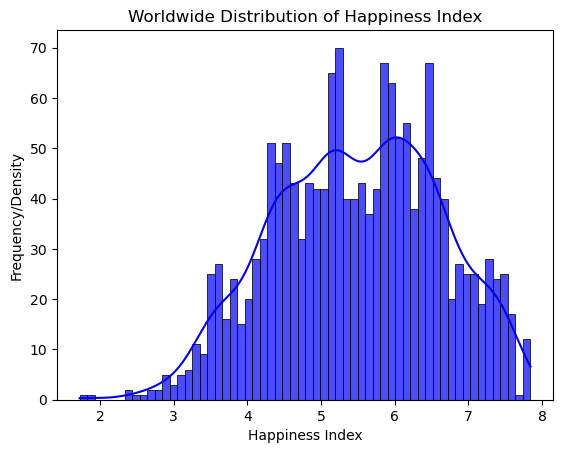

In [48]:
#make a histogram to visualize distribution of happiness to visualize and interpret better

#add a kernel density estimate line
sns.histplot(data=merged_df, x='Happiness Index', kde=True, bins=60, color='blue', alpha=0.7)
plt.title('Worldwide Distribution of Happiness Index')
plt.xlabel('Happiness Index')
plt.ylabel('Frequency/Density')
plt.savefig('data/figures/Distribution.png')
plt.show()

In [49]:
# print highest and lowest scores
highest_happiness = merged_df.loc[merged_df['Happiness Index'].idxmax()]
lowest_happiness = merged_df.loc[merged_df['Happiness Index'].idxmin()]
print("Highest Happiness Index:")
print(f"Country: {highest_happiness['Country']}, Year: {highest_happiness['Year']}, Score: {highest_happiness['Happiness Index']}")
print("Lowest Happiness Index:")
print(f"Country: {lowest_happiness['Country']}, Year: {lowest_happiness['Year']}, Score: {lowest_happiness['Happiness Index']}")

Highest Happiness Index:
Country: Finland, Year: 2021, Score: 7.842
Lowest Happiness Index:
Country: Afghanistan, Year: 2024, Score: 1.721


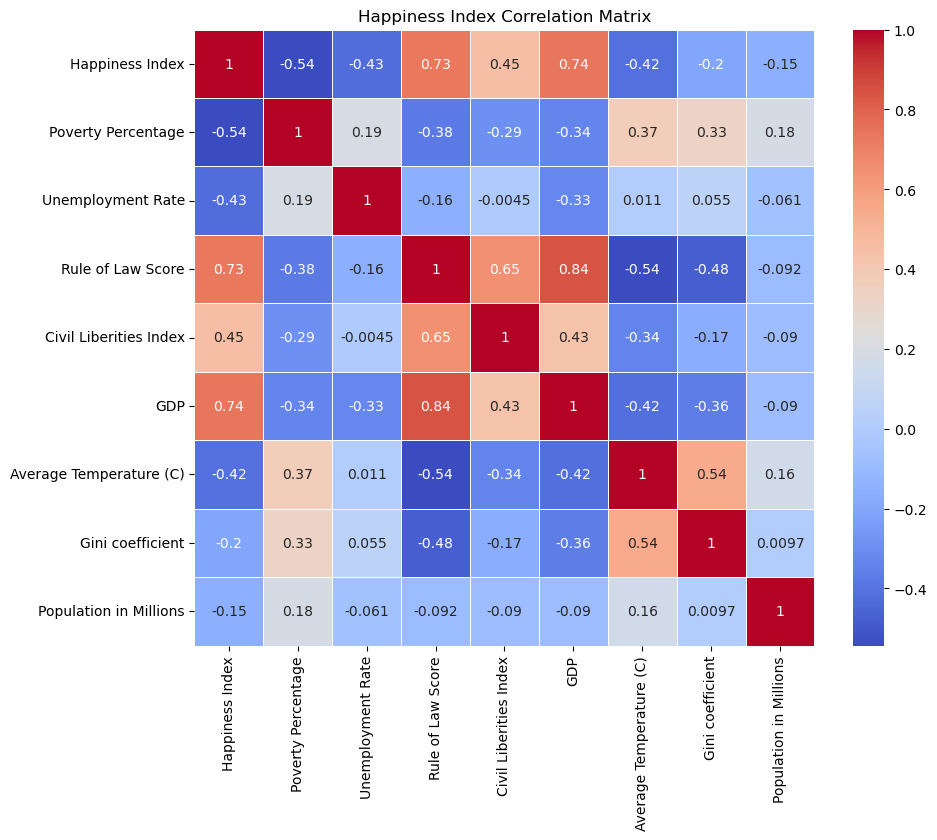

Correlations with Happiness Index:
Happiness Index            1.000000
GDP                        0.735061
Rule of Law Score          0.730211
Civil Liberities Index     0.452621
Population in Millions    -0.154157
Gini coefficient          -0.203445
Average Temperature (C)   -0.415208
Unemployment Rate         -0.425105
Poverty Percentage        -0.543168
Name: Happiness Index, dtype: float64


In [50]:

#Selecting the relevant columns for the correlation matrix
columns_of_interest = [
    'Happiness Index',
    'Poverty Percentage',
    'Unemployment Rate',
    'Rule of Law Score',
    'Civil Liberities Index',
    'GDP',
    'Average Temperature (C)',
    'Gini coefficient',
    'Population in Millions'
    
    
]
#ensure columns are numeric 
subset_df = merged_df[columns_of_interest].replace('No Data', None)
subset_df = subset_df.apply(pd.to_numeric, errors='coerce')

#compute correlation
correlation_matrix = subset_df.corr()

#Plot the correlation on a matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Happiness Index Correlation Matrix')
plt.savefig('data/figures/correlation.png')
plt.show()

happiness_correlations = correlation_matrix['Happiness Index'].sort_values(ascending=False)
print("Correlations with Happiness Index:")
print(happiness_correlations)

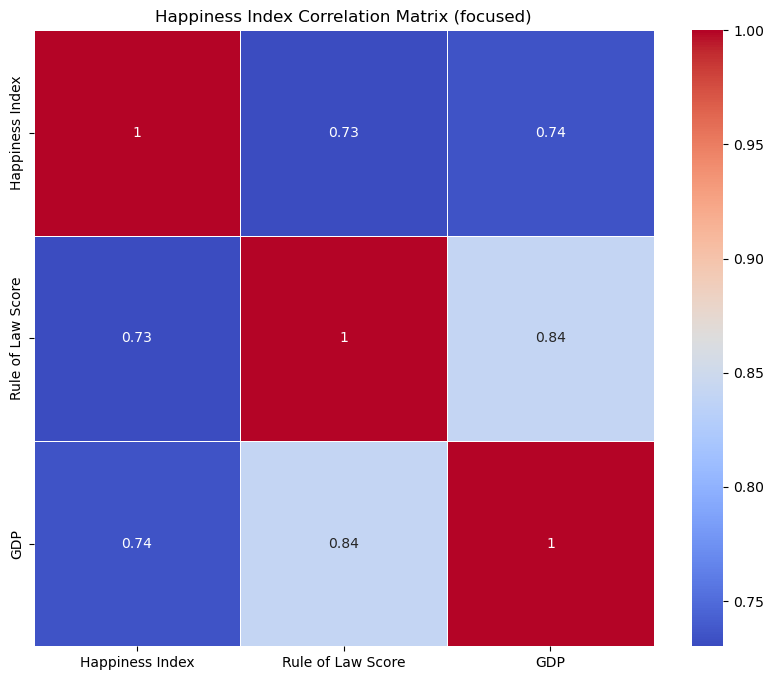

In [51]:
subset_df=merged_df[['Happiness Index', 'Rule of Law Score', 'GDP']]
subset_df = subset_df.apply(pd.to_numeric, errors='coerce')

correlation_matrix = subset_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Happiness Index Correlation Matrix (focused)')
plt.savefig('data/figures/correlation_focused.png')
plt.show()


 Takeaway:\
    no real outliers

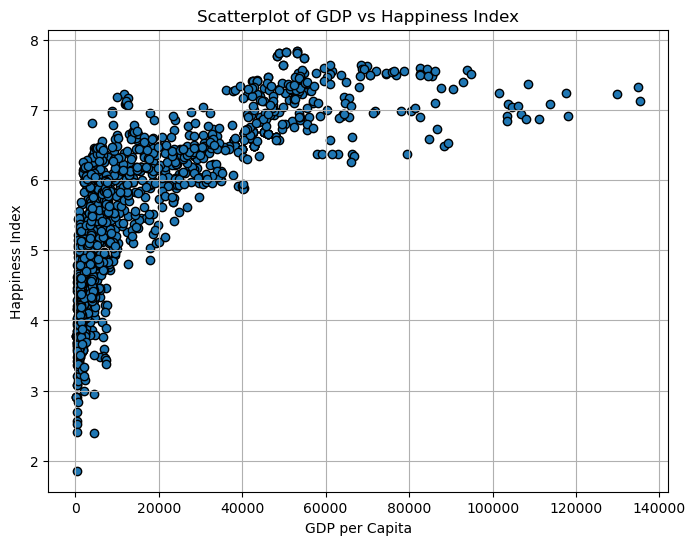

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
#important step: make sure to replace the no data strings with nothing
subset_df = merged_df.replace('No Data', None)
subset_df['GDP'] = pd.to_numeric(subset_df['GDP'], errors='coerce') # replaces data with no input with NaN #citation 1
#https://stackoverflow.com/questions/61668492/missing-values-in-pandas-using-errors-coerce
#plot
plt.figure(figsize=(8, 6))
plt.scatter(subset_df['GDP'], subset_df['Happiness Index'], edgecolors='k')

plt.title('Scatterplot of GDP vs Happiness Index')
plt.xlabel('GDP per Capita')
plt.ylabel('Happiness Index')
plt.grid(True)
plt.savefig('data/figures/GDP.png')
plt.show()

In [53]:
# very clear curve that levels out

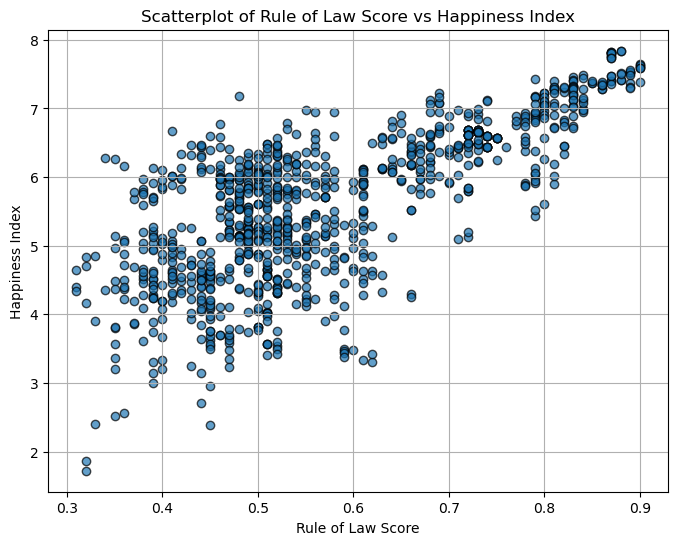

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
# same steps as last, but with poverty percentage
subset_df = merged_df.replace('No Data', None)
subset_df['Rule of Law Score'] = pd.to_numeric(subset_df['Rule of Law Score'], errors='coerce')
subset_df['Happiness Index'] = pd.to_numeric(subset_df['Happiness Index'], errors='coerce')

plt.figure(figsize=(8, 6))
plt.scatter(subset_df['Rule of Law Score'], subset_df['Happiness Index'], alpha=0.7, edgecolors='k')

plt.title('Scatterplot of Rule of Law Score vs Happiness Index')
plt.xlabel('Rule of Law Score')
plt.ylabel('Happiness Index')
plt.grid(True)
plt.savefig('data/figures/ROL.png')
plt.show()

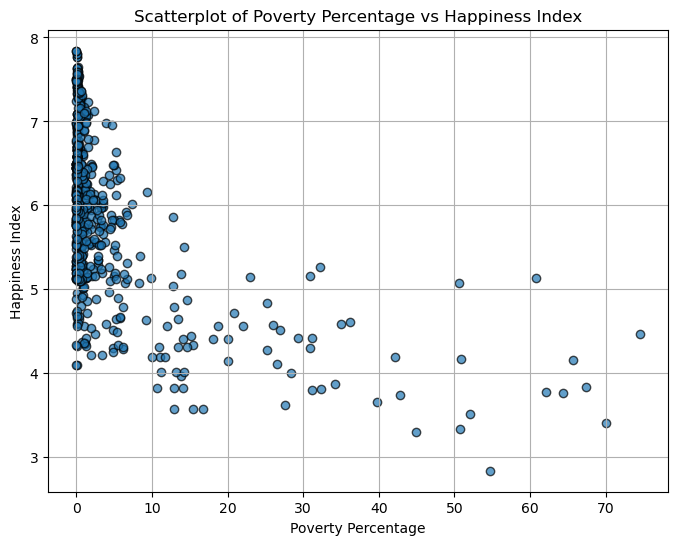

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
# same steps as last, but with poverty percentage
subset_df = merged_df.replace('No Data', None)
subset_df['Poverty Percentage'] = pd.to_numeric(subset_df['Poverty Percentage'], errors='coerce')
subset_df['Happiness Index'] = pd.to_numeric(subset_df['Happiness Index'], errors='coerce')

plt.figure(figsize=(8, 6))
plt.scatter(subset_df['Poverty Percentage'], subset_df['Happiness Index'], alpha=0.7, edgecolors='k')

plt.title('Scatterplot of Poverty Percentage vs Happiness Index')
plt.xlabel('Poverty Percentage')
plt.ylabel('Happiness Index')
plt.grid(True)
plt.savefig('data/figures/poverty.png')
plt.show()

# Analysis

1. Preform linear regressions with each variable to see how they preform. 

2. Do a multivariable regression 

3. visualize a multivariable linear regression with all variables. 

4. Kmeans Clustering to investigate anomalies. 



In [56]:
# my idea is to create a function that will create a linear regression over each score and return its MSE and R squared value
#which will help me further decide which variables to include and exclude in my multivariable regression
def linregress(data, target_column, features):
    results = []  
    predictions_df = pd.DataFrame() 
    
    for feature in features:
       #clean and prepare the data 
        subset_df = data.replace(['No Data', 'no data'], None)
        subset_df[feature] = pd.to_numeric(subset_df[feature], errors='coerce')         
        subset_df[target_column] = pd.to_numeric(subset_df[target_column], errors='coerce')
        subset_df = subset_df.dropna(subset=[target_column, feature])
        #scale
        if feature == 'GDP':
            subset_df[feature] = subset_df[feature] / 100
        
        # define X and y
        X = subset_df[[feature]]
        y = subset_df[target_column]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
        model = LinearRegression()
        model.fit(X_train, y_train)
        #make predictions
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        #append results to empty list
        results.append({
            'Feature': feature,
            'Mean Squared Error': mse,
            'R-Squared Score': r2,
        })
    return results

#define target features
columns_of_interest = [
    'Poverty Percentage',
    'Unemployment Rate',
    'Rule of Law Score',
    'Civil Liberities Index',
    'GDP',
    'Average Temperature (C)',
    'Gini coefficient',
    'Population in Millions'
]
results = linregress(merged_df, 'Happiness Index', columns_of_interest)
#save results 
results_df = pd.DataFrame(results)
results_df.to_csv('data/RSCORES.csv', index=False)
# Print summary results
print(results_df)

                   Feature  Mean Squared Error  R-Squared Score
0       Poverty Percentage            0.708895         0.279156
1        Unemployment Rate            0.657077         0.127598
2        Rule of Law Score            0.513776         0.580445
3   Civil Liberities Index            0.963724         0.242382
4                      GDP            0.546408         0.566906
5  Average Temperature (C)            0.998732         0.198987
6         Gini coefficient            0.885633         0.067095
7   Population in Millions            1.238877         0.018041


Mean Squared Error: 0.23984281723658363
R-Squared Score: 0.6370089530539883
Coefficients:[-0.1328312   0.35692984 -0.18381521  0.64075841  0.31210922]
intercept: 6.165059471750681
Predicted and Actual Happiness Index for Each Country and Year:
         Country  Year  Predicted_Happiness  Happiness Index
10       Albania  2015             4.802064           4.9590
11       Albania  2016             4.884969           4.6550
12       Albania  2016             4.884969           4.6550
13       Albania  2017             4.921907           4.6440
14       Albania  2017             4.921907           4.6440
...          ...   ...                  ...              ...
1579     Uruguay  2022             6.370682           6.4740
1589  Uzbekistan  2022             5.601024           6.0630
1603     Vietnam  2016             5.897922           5.0610
1607     Vietnam  2020             6.015284           5.3535
1609     Vietnam  2022             6.030299           5.4850

[342 rows x 4 columns]


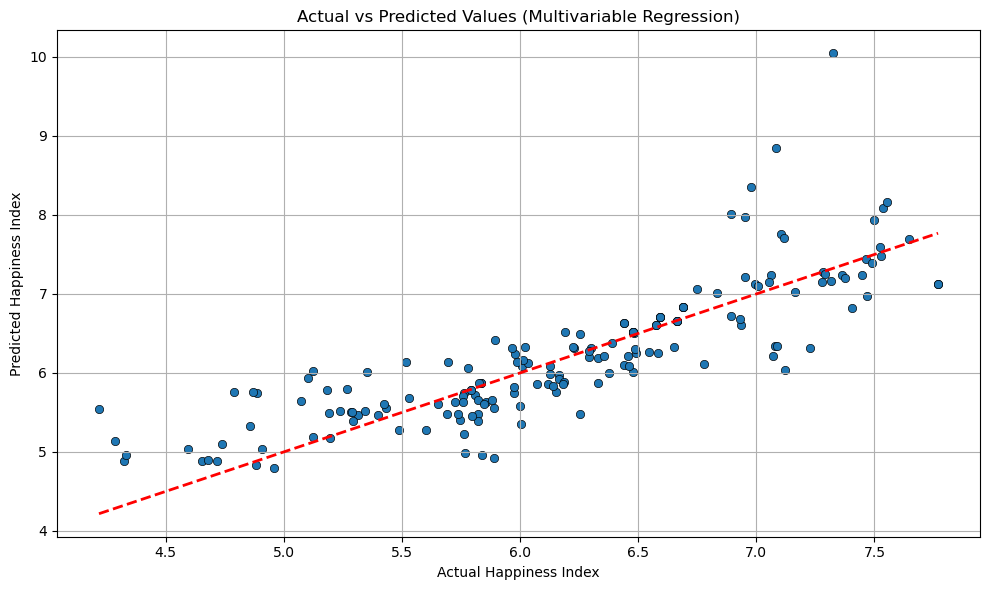

Cross-Validated R2 Scores: [0.55322157 0.70052115 0.64727193 0.50825703 0.70784843]
Mean CV R2 Score: 0.6234240237476758


In [57]:
# MULTIVARIABLE REGRESSION FOR ALL DATA POINTS
# I am preparing the data by creating a subset and by droping all nans
columns_of_interest = [
    'Unemployment Rate',
    'Rule of Law Score',
    'Civil Liberities Index',
    'GDP',
    'Gini coefficient',
]

#replace no data rows
subset_df = merged_df.replace(['No Data', 'no data'], np.nan)
subset_df = subset_df.dropna(subset=columns_of_interest)
subset_df[columns_of_interest] = subset_df[columns_of_interest].apply(pd.to_numeric, errors='coerce')
#define independent and dependent variables 
X = subset_df[columns_of_interest] 
y = subset_df['Happiness Index']
#scale data since we are dealing with many variables 
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

#train model
model = LinearRegression()
model.fit(X_train, y_train)
#predictions
y_pred = model.predict(X_test)
#evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
coefficients = model.coef_
intercept = model.intercept_

# I am using model.predict to predict on the whole mode. 
subset_df['Predicted_Happiness'] = model.predict(X)

y_pred = model.predict(X_test)

print(f"Mean Squared Error: {mse}")
print(f"R-Squared Score: {r2}")
print(f"Coefficients:{coefficients}")
print(f"intercept: {intercept}")
print("Predicted and Actual Happiness Index for Each Country and Year:")
print(subset_df[['Country', 'Year', 'Predicted_Happiness', 'Happiness Index']])
# Visualization: Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=1, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
plt.title('Actual vs Predicted Values (Multivariable Regression)')
plt.xlabel('Actual Happiness Index')
plt.ylabel('Predicted Happiness Index')
plt.grid(True)
plt.tight_layout()
plt.savefig('data/figures/multivariable_regression.png')
plt.show()

#IMPORTANT: PERFORM A CROSS VALIDATION SCORE TO EVAULATE MODEL ACCURACY 
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-Validated R2 Scores: {cv_scores}")  #TAKES AN R SCORE FOR 5 different folds 
print(f"Mean CV R2 Score: {cv_scores.mean()}")

In [58]:
# I want to make a kmeans cluster of GDP, because it is the datapoint where so far I have observed the most anomalies
# I am selecting gdp per capita because it is the most relevant feature here. 
features = ['Happiness Index', 'GDP']
subset_df = merged_df[features + ['Country']].replace(['No Data', 'no data'], np.nan)
# to numeric
subset_df[features] = subset_df[features].apply(pd.to_numeric, errors='coerce')
# drop rows with no values 
subset_df = subset_df.dropna()
#use the scaling feature
scaler = StandardScaler()
scaled_features = scaler.fit_transform(subset_df[features])
# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42) 
subset_df['Cluster'] = kmeans.fit_predict(scaled_features)

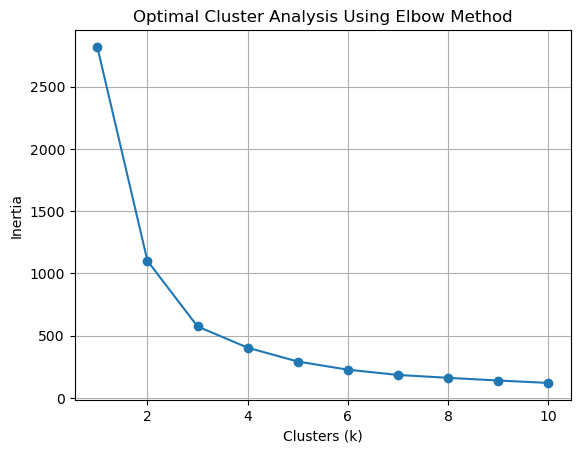

In [59]:
inertias = [] #initialzie 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42) 
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_) #store in empty list
        
plt.plot(range(1, 11), inertias, marker='o')
plt.title("Optimal Cluster Analysis Using Elbow Method")
plt.xlabel("Clusters (k)")
plt.ylabel("Inertia")
plt.grid()
plt.savefig('plt_elbow.png')
plt.show()

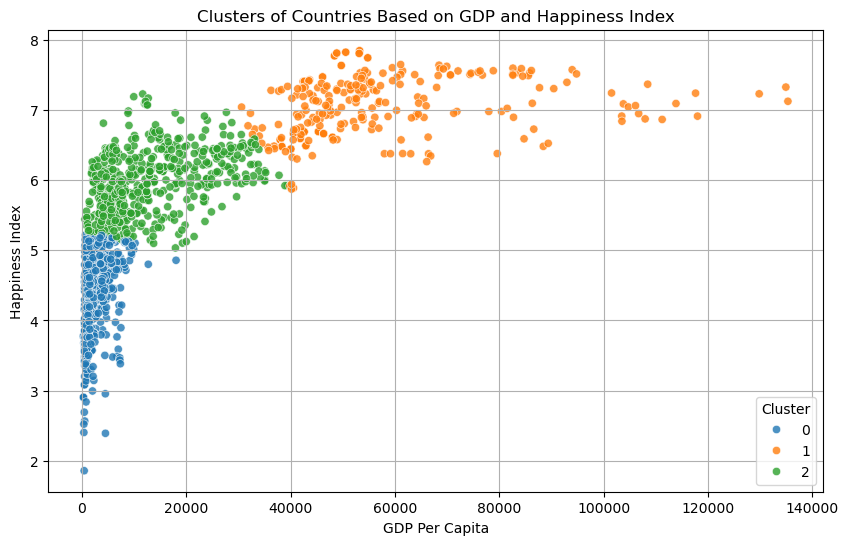

In [60]:
# plot clusters 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=subset_df, x='GDP', y='Happiness Index', hue='Cluster', palette='tab10', alpha=0.8)
plt.title('Clusters of Countries Based on GDP and Happiness Index')
plt.xlabel('GDP Per Capita')
plt.ylabel('Happiness Index')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig('data/figures/clusters.png')
plt.show()

In [61]:
# CLuster 2 is the most interesting
happy_outliers = subset_df[(subset_df['Happiness Index'] > 6) & (subset_df['GDP'] < subset_df['GDP'].median())]
happy_outliers = happy_outliers.drop_duplicates(subset=['Country'])

print("Happy Outliers:")
print(happy_outliers[['Country', 'Happiness Index', 'GDP']])
print(len(happy_outliers))

Happy Outliers:
          Country  Happiness Index       GDP
24        Algeria            6.355  4426.580
312      Colombia            6.477  6337.030
411       Ecuador            6.008  6220.968
429   El Salvador            6.130  3761.493
597     Guatemala            6.123  3994.231
631      Honduras            6.022  3033.970
764       Jamaica            6.309  5354.830
812        Kosovo            6.100  4432.996
1101    Nicaragua            6.071  2147.856
1207  Philippines            6.006  3312.739
1408     Suriname            6.269  5762.414
1468     Thailand            6.455  5838.399
1582   Uzbekistan            6.003  2761.290
1592    Venezuela            6.810  4096.971
1611      Vietnam            6.043  4649.054
15


In [62]:
# calculate correlation between happiness and years
merged_df['Year'] = pd.to_numeric(merged_df['Year'], errors='coerce')
merged_df['Happiness Index'] = pd.to_numeric(merged_df['Happiness Index'], errors='coerce')
correlation = merged_df['Year'].corr(merged_df['Happiness Index'])
print(f"Correlation between Happiness and Year: {correlation:.2f}")

Correlation between Happiness and Year: 0.07


In [32]:
# venezuela

# finally done 